<a href="https://www.kaggle.com/code/minseo14/arc-task-00d62c1b-build-a-model?scriptVersionId=189134946" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 00d62c1b's Time!
> ### Models in this page are specialized only for the single data, 00d62c1b. 
> ### Still a necessary step though!

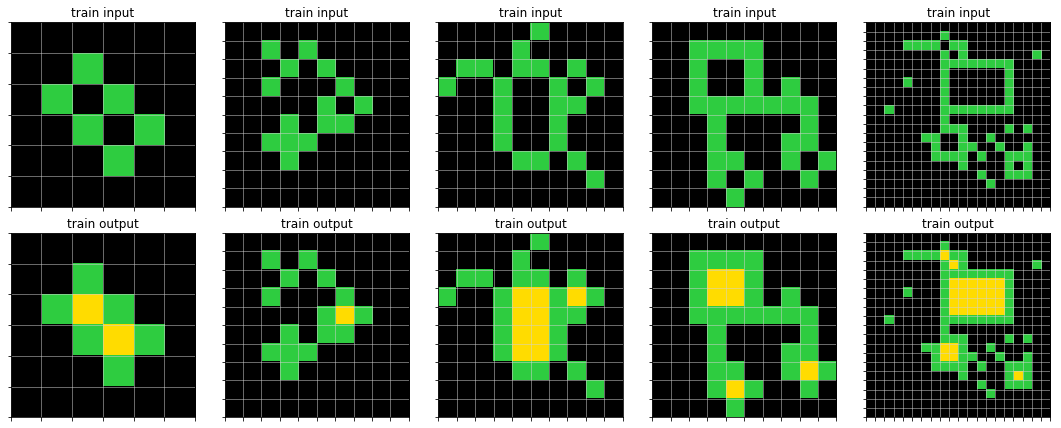

## Abastract
    CNNs seems have a limitation to detect all borders without long term memory.
### Next Step 
    Apply boundary fill algorithm from the border of the image detecting nearby pixels having the same color. 
    Then detect the significant rest pixels

### Extention (To aproach end-to-end)
    Classify whether the shape is stable or not.
    Predict what kind of pattern/roles each task/color has.
    
### Citation of code
> [Basic Attention Model - deep-learning-from-scratch-2](https://github.com/oreilly-japan/deep-learning-from-scratch-2/tree/master/ch08)

---

# Step 0: Setup

## 0-1. Install Libraries and Import Modules

> ### Add Path

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arcsourcecode/data.py
/kaggle/input/arcsourcecode/train.py
/kaggle/input/arcsourcecode/test.py
/kaggle/input/arcsourcecode/constants.py
/kaggle/input/arcsourcecode/classify.py
/kaggle/input/arcsourcecode/2_00d62c1b.png
/kaggle/input/arcsourcecode/utils/analyze.py
/kaggle/input/arcsourcecode/utils/lightning_custom.py
/kaggle/input/arcsourcecode/utils/visualize.py
/kaggle/input/arcsourcecode/configs/train.yaml
/kaggle/input/arcsourcecode/configs/test.yaml
/kaggle/input/arcsourcecode/configs/model/ShapeStableSolverIgnoreColor.yaml
/kaggle/input/arcsourcecode/configs/model/ShapeStableSolver.yaml
/kaggle/input/arcsourcecode/configs/data/ShapeStableSolverIgnoreColor_test.yaml
/kaggle/input/arcsourcecode/configs/data/ShapeStableSolver_train.yaml
/kaggle/input/arcsourcecode/configs/data/train.yaml
/kaggle/input/arcsourcecode/configs/data/ShapeStableSolverIgnoreColor_train.yaml
/kaggle/input/arcsourcecode/configs/data/ShapeStableSolver_test.yaml
/kaggle/input/arcsourcecode/configs

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/arcsourcecode')

> ### Install Hydra

In [3]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.1 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=fd246d4da060486d28b0cfcc3b03452a5da6ff32f66123a188f785fd340decf1
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


> ### Load Config Files and Train/Test Functions

In [4]:
from omegaconf import OmegaConf
from train import train
from test import test

In [5]:
base_path = '/kaggle/input/arc-prize-2024/'
config_path = '/kaggle/input/arcsourcecode/configs/'

def load_config(path, config_path=config_path):
    return OmegaConf.load(config_path + path)

def load_train_config(ignore_color=False):
    if ignore_color:
        # Hyperparameters for Training
        config_data = load_config("data/ShapeStableSolverIgnoreColor_train.yaml")
        config_model = load_config("model/ShapeStableSolverIgnoreColor.yaml")
        config_train = load_config("train/default.yaml")
        config_train_default = OmegaConf.load(config_path + "train.yaml")
    else:
        # Hyperparameters for Training
        config_data = load_config("data/ShapeStableSolver_train.yaml")
        config_model = load_config("model/ShapeStableSolver.yaml")
        config_train = load_config("train/default.yaml")
        config_train_default = OmegaConf.load(config_path + "train.yaml")
        
    config_train = OmegaConf.merge({'data': config_data, 'model': config_model, 'train': config_train, **config_train_default})

    config_train.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    config_train.save_path = './output/'
    
    return config_train

def load_test_config(train=False, ignore_color=False):
    if ignore_color:
        # Hyperparameters for Testing
        config_data = load_config("data/ShapeStableSolverIgnoreColor_test.yaml")
        config_model = load_config("model/ShapeStableSolverIgnoreColor.yaml")
        config_test_default = load_config("test.yaml")
        config_test = OmegaConf.merge({'data': config_data, 'model': config_model, **config_test_default})
    else:
        # Hyperparameters for Testing
        config_data = load_config("data/ShapeStableSolver_test.yaml")
        config_model = load_config("model/ShapeStableSolver.yaml")
        config_test_default = load_config("test.yaml")
    
    config_test = OmegaConf.merge({'data': config_data, 'model': config_model, **config_test_default})
    config_test.data.params.base_path = '/kaggle/input/arc-prize-2024/'
    
    return config_test

## 0-2. Data Augmentation (Rotation, Flipping)

Data size: 1

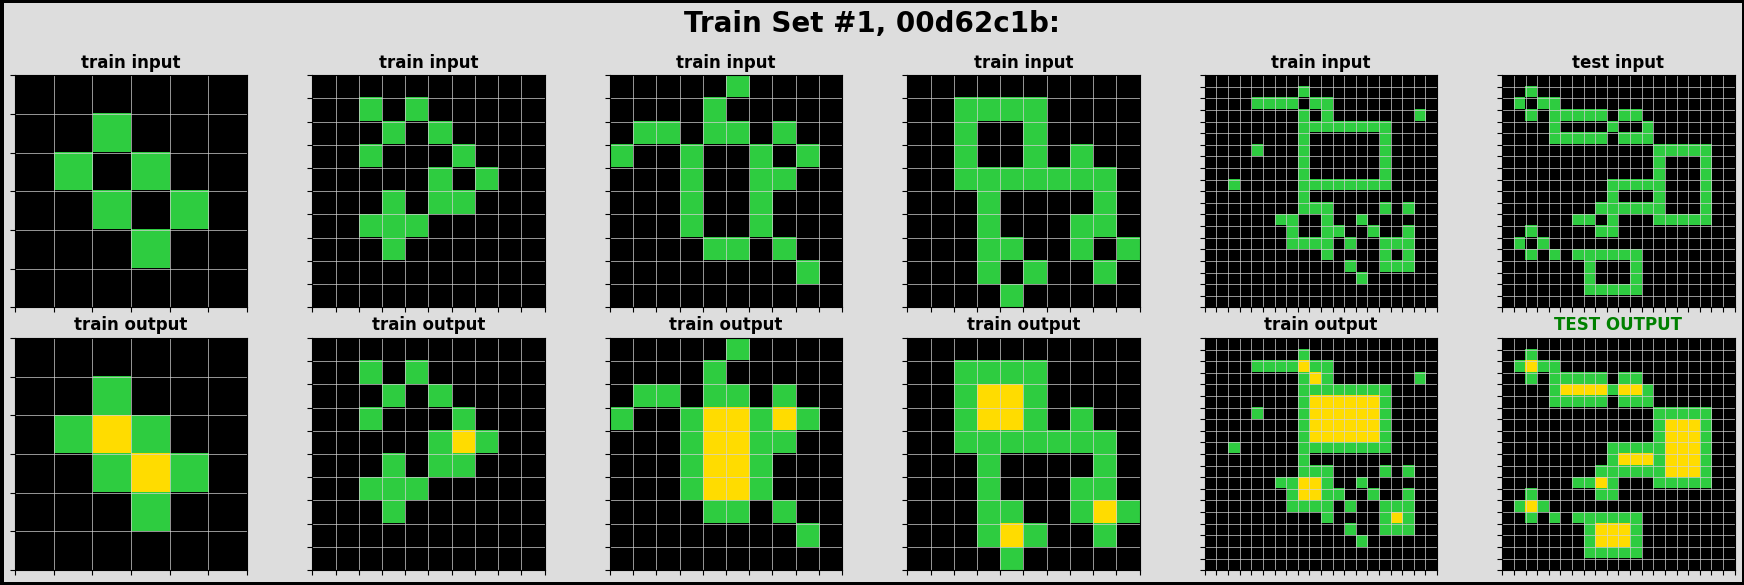

In [6]:
from rich import print
from data import ARCDataset
from constants import get_challenges_solutions_filepath
from classify import ARCDataClassifier
from utils.visualize import plot_task


data_category = 'train'
challenges, solutions = get_challenges_solutions_filepath(data_category, base_path)

# Filtering Dataset
filter_funcs = (
    ARCDataClassifier.in_data_codes_f(['00d62c1b']),
#     ARCDataClassifier.is_same_shape_f(True),
#     ARCDataClassifier.is_n_m_colored_in_out_f(2, 3),
#     ARCDataClassifier.is_dominent_color_stable_f(True),
)

dataset_train = ARCDataset(challenges, solutions, train=True, one_hot=False, filter_funcs=filter_funcs)
dataset_test = ARCDataset(challenges, solutions, train=False, one_hot=False, filter_funcs=filter_funcs)
print(f'Data size: {len(dataset_train)}')

# Visualize a task
for index in range(len(dataset_train)):
    plot_task(dataset_train, dataset_test, index, data_category)
    break

Data size: 1

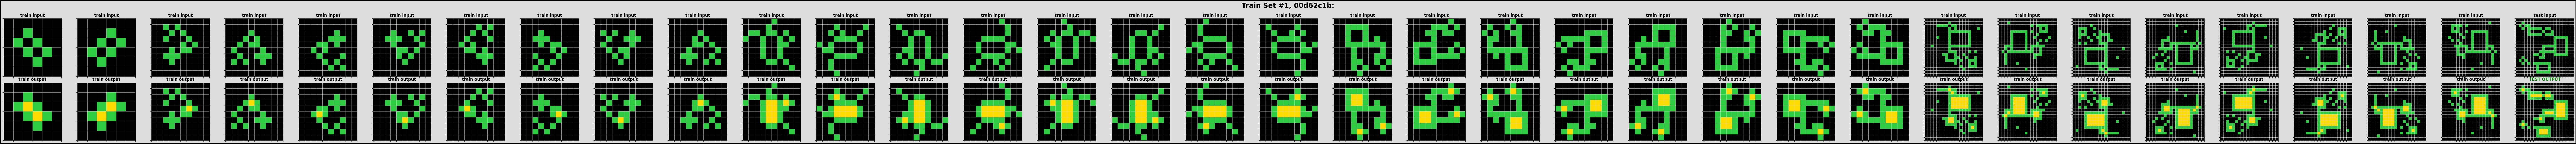

In [7]:
dataset_train = ARCDataset(challenges, solutions, train=True, one_hot=False, filter_funcs=filter_funcs, augment_data=True)
print(f'Data size: {len(dataset_train)}')

# Visualize a task
for index in range(len(dataset_train)):
    plot_task(dataset_train, dataset_test, index, data_category='Train')
    break

# Step 1: Consider which pixel to be substituted

## 1-1. Predict the positions to be substituted

In [8]:
config = load_train_config(ignore_color=True)
train(config)

data:
  name: ShapeStableSolverIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: ShapeStableSolverIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: ShapeStableSolver_train
- model: ShapeStableSolver
- train: default
save_path: ./output/

2024-07-21 06:37:08.954050: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 06:37:08.954220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 06:37:09.148684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolverIgnoreColor │ 98.6 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss            │      0 │ train │
└───┴────────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 98.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 98.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 
does not match num_features. You can silence this warning by not passing in num_features, which is not used because
affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Train loss: 22.621517, N Pixels Wrong: 1435

Train loss: 21.470448, N Pixels Wrong: 1379

Train loss: 20.668150, N Pixels Wrong: 536

Train loss: 20.195913, N Pixels Wrong: 338

Train loss: 19.493624, N Pixels Wrong: 302

Train loss: 19.093603, N Pixels Wrong: 161

Train loss: 18.803095, N Pixels Wrong: 47

Train loss: 18.745045, N Pixels Wrong: 23

Train loss: 18.719469, N Pixels Wrong: 11

Train loss: 18.711588, N Pixels Wrong: 10

Train loss: 18.702995, N Pixels Wrong: 4

Train loss: 18.699888, N Pixels Wrong: 3

Train loss: 18.700443, N Pixels Wrong: 2

Train loss: 18.701324, N Pixels Wrong: 2

Train loss: 18.701679, N Pixels Wrong: 2

Train loss: 18.700373, N Pixels Wrong: 1

Train loss: 18.697617, N Pixels Wrong: 1

Train loss: 18.695393, N Pixels Wrong: 0

Train loss: 18.698641, N Pixels Wrong: 0

Train loss: 18.704149, N Pixels Wrong: 0

Train loss: 18.707800, N Pixels Wrong: 0

Train loss: 18.701864, N Pixels Wrong: 0

Train loss: 18.696915, N Pixels Wrong: 0

Train loss: 18.699518, N Pixels Wrong: 0

Train loss: 18.704189, N Pixels Wrong: 4

Train loss: 18.701487, N Pixels Wrong: 0

Train loss: 18.697945, N Pixels Wrong: 2

Train loss: 18.697130, N Pixels Wrong: 0

Train loss: 18.700367, N Pixels Wrong: 0

Train loss: 18.700094, N Pixels Wrong: 0

Train loss: 18.697033, N Pixels Wrong: 0

Train loss: 18.696445, N Pixels Wrong: 0

Train loss: 18.698112, N Pixels Wrong: 0

Train loss: 18.697348, N Pixels Wrong: 0

Train loss: 18.696903, N Pixels Wrong: 0

Train loss: 18.696926, N Pixels Wrong: 0

Train loss: 18.697680, N Pixels Wrong: 0

Train loss: 18.697090, N Pixels Wrong: 0

Train loss: 18.696716, N Pixels Wrong: 0

Train loss: 18.697481, N Pixels Wrong: 0

Train loss: 18.696657, N Pixels Wrong: 1

Train loss: 18.696983, N Pixels Wrong: 1

Train loss: 18.698090, N Pixels Wrong: 0

Train loss: 18.697222, N Pixels Wrong: 0

Train loss: 18.697266, N Pixels Wrong: 0

Train loss: 18.696709, N Pixels Wrong: 0

Train loss: 18.697092, N Pixels Wrong: 0

Train loss: 18.696514, N Pixels Wrong: 0

Train loss: 18.697220, N Pixels Wrong: 1

Train loss: 18.696072, N Pixels Wrong: 0

Seed used 2235942772391737771

Model saved to: ./output//model_ShapeStableSolverIgnoreColor.pth

ShapeStableSolverIgnoreColorL(
  (model): ShapeStableSolverIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3),

data:
  name: ShapeStableSolverIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: false
    ignore_color: true
model:
  name: ShapeStableSolverIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
defaults:
- data: ShapeStableSolver_test
- model: ShapeStableSolver
- train: default
model_path: ./output/model_ShapeStableSolverIgnoreColor.pth
verbose_single: false

Task: 00d62c1b, index: 1, correct 0.0%, N Pixels Wrong: 36

Task: 00d62c1b, index: 2, correct 0.0%, N Pixels Wrong: 100

Task: 00d62c1b, index: 3, correct 0.0%, N Pixels Wrong: 100

Task: 00d62c1b, index: 4, correct 0.0%, N Pixels Wrong: 100

Task: 00d62c1b, index: 5, correct 0.0%, N Pixels Wrong: 400

Task: 00d62c1b, index: 6, correct 0.0%, N Pixels Wrong: 400

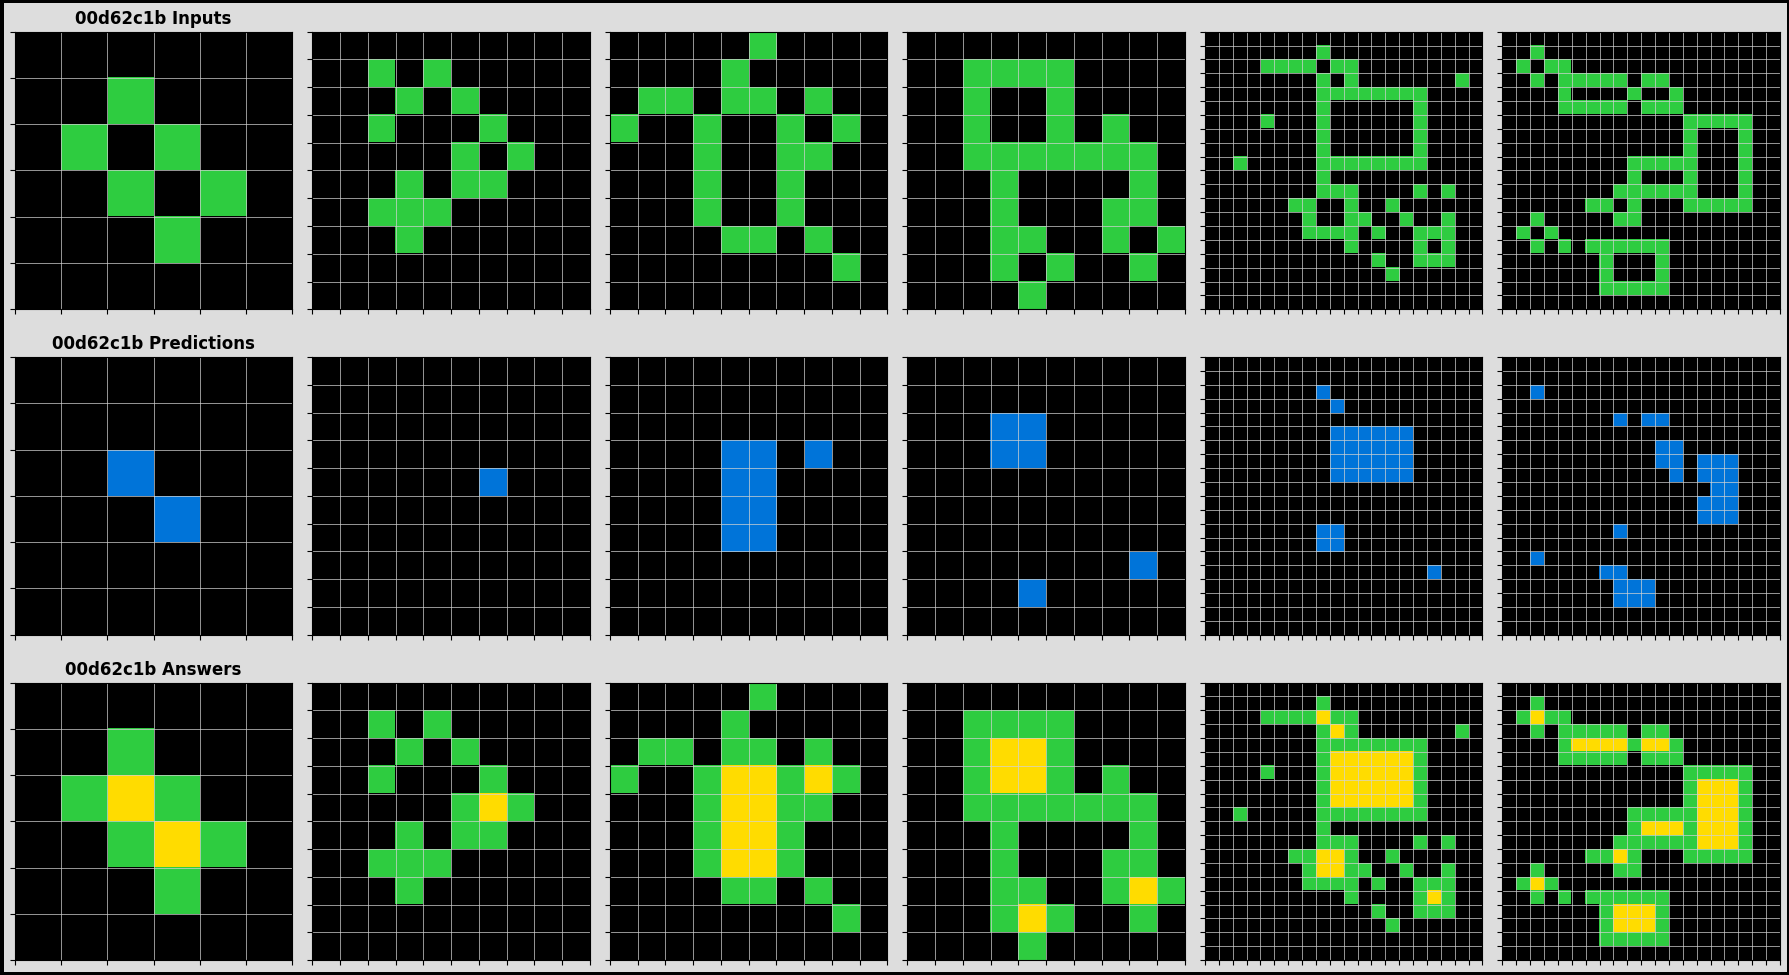

In [9]:
config = load_test_config(ignore_color=True)
config.model_path = './output/model_ShapeStableSolverIgnoreColor.pth'
test(config)

# Step 2: Consider pixel colors as well

## 2-1. Predict pixels to be kept

In [10]:
import torch
from torch import nn


class ShapeStableSolver(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], hidden_size=1, num_classes=10, feature_dim=1, color_dim=1):
        super().__init__()
        self.color_vector = nn.Parameter(torch.randn(num_classes, feature_dim)) # dim-1 because the first channel is the input

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )

        self.decoder = nn.Sequential(
            nn.Linear(color_dim, 1, bias=False),
        )

    def forward(self, x):
        N, C, H, W = x.shape

        y = self.color_vector.repeat(N*H*W, 1, 1) # [N*H*W, C, V]
        V = y.shape[2]
        y = y.transpose(2, 1) # [N*H*W, V, C]

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1) # [N*H*W, V, C]
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    epoch: 10
    lr: 0.01
defaults:
- data: ShapeStableSolver_train
- model: ShapeStableSolver
- train: default
save_path: ./output/

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolver │    861 │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss │      0 │ train │
└───┴────────────────┴───────────────────┴────────┴───────┘

Trainable params: 861                                                                                              
Non-trainable params: 0                                                                                            
Total params: 861                                                                                                  
Total estimated model params size (MB): 0

Output()

Train loss: 21.525152, N Pixels Wrong: 1433

Train loss: 17.833477, N Pixels Wrong: 603

Train loss: 13.538609, N Pixels Wrong: 1391

Train loss: 9.904122, N Pixels Wrong: 1462

Train loss: 7.430528, N Pixels Wrong: 1456

Train loss: 6.063508, N Pixels Wrong: 1456

Train loss: 5.308712, N Pixels Wrong: 1456

Train loss: 4.877787, N Pixels Wrong: 1454

Train loss: 4.602780, N Pixels Wrong: 1447

Train loss: 4.402553, N Pixels Wrong: 1333

Seed used 15663097962282638499

Model saved to: ./output//model_ShapeStableSolver.pth

Task: 00d62c1b, index: 1, correct 77.77777862548828%, N Pixels Wrong: 8

Task: 00d62c1b, index: 2, correct 84.0%, N Pixels Wrong: 16

Task: 00d62c1b, index: 3, correct 69.0%, N Pixels Wrong: 31

Task: 00d62c1b, index: 4, correct 65.0%, N Pixels Wrong: 35

Task: 00d62c1b, index: 5, correct 75.5%, N Pixels Wrong: 98

Task: 00d62c1b, index: 6, correct 72.25%, N Pixels Wrong: 111

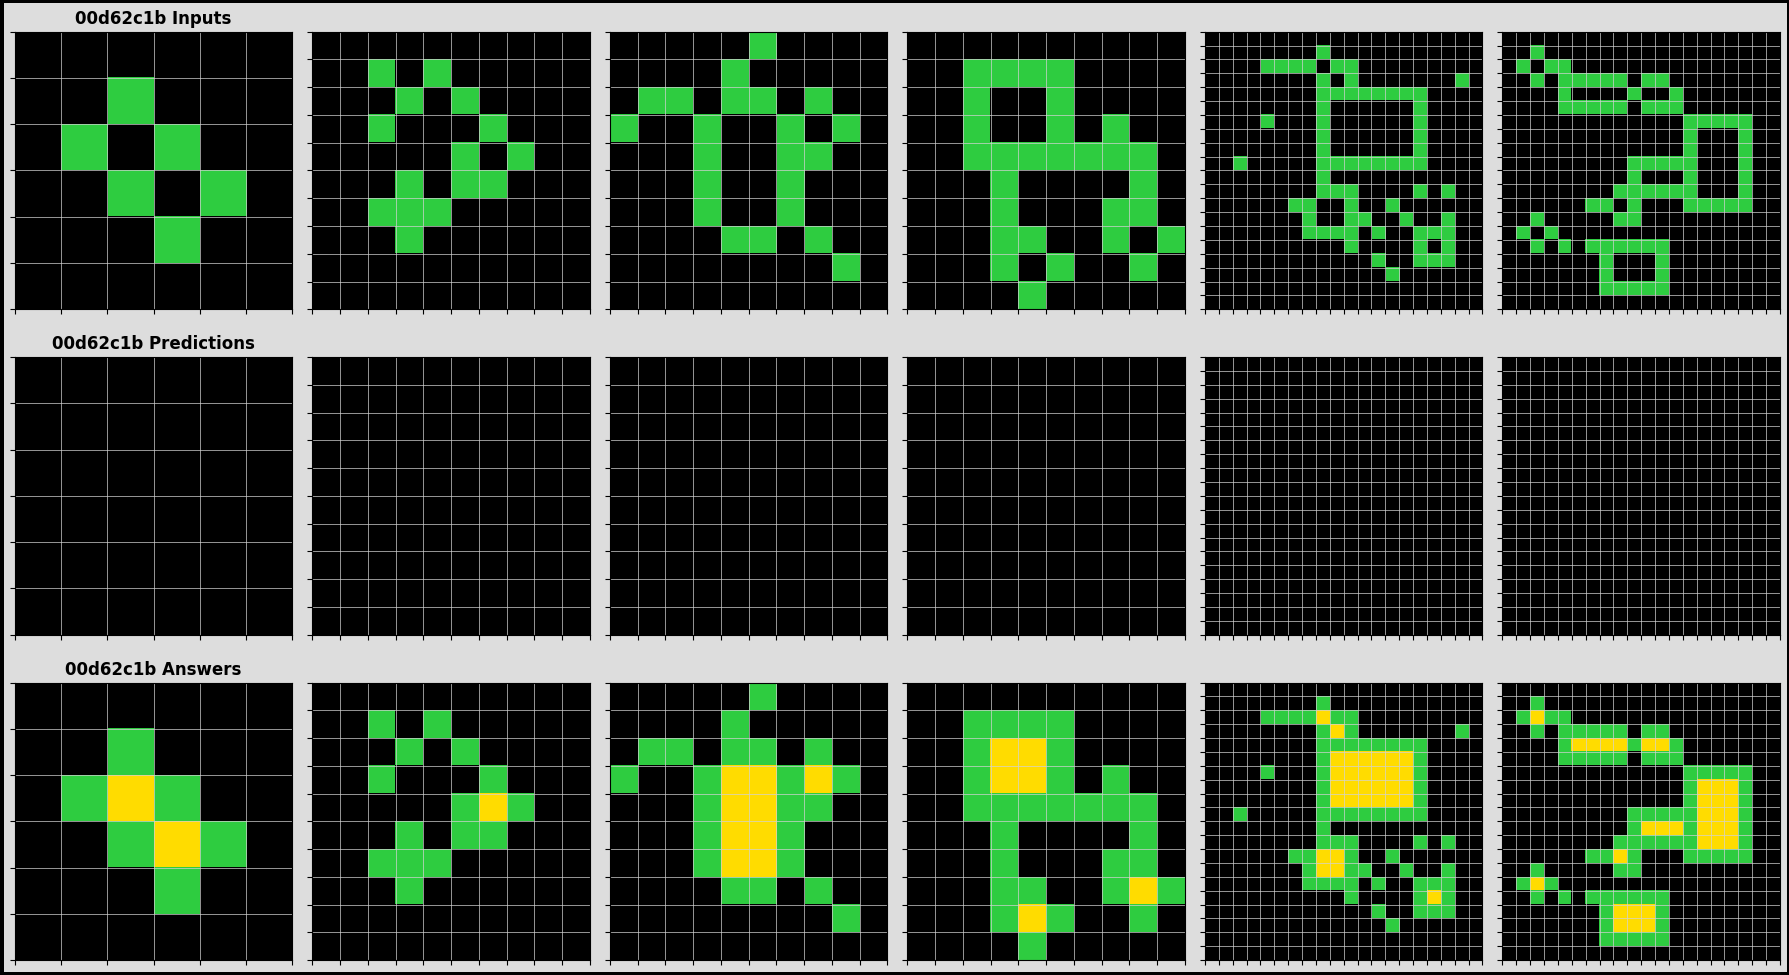

In [11]:
config = load_train_config()
config.train.params.epoch = 10
model = train(config, ShapeStableSolver) # Apply custom model

config = load_test_config()
test(config, model)

## 2-2. Predict which pixels to be kept and replaced by which color

In [12]:
config = load_train_config()
train(config)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: ShapeStableSolver_train
- model: ShapeStableSolver
- train: default
save_path: ./output/

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolver │ 31.8 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss │      0 │ train │
└───┴────────────────┴───────────────────┴────────┴───────┘

Trainable params: 31.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 31.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 16.834282, N Pixels Wrong: 684

Train loss: 11.430387, N Pixels Wrong: 380

Train loss: 8.656730, N Pixels Wrong: 380

Train loss: 6.907917, N Pixels Wrong: 380

Train loss: 5.719431, N Pixels Wrong: 380

Train loss: 4.864996, N Pixels Wrong: 380

Train loss: 4.172994, N Pixels Wrong: 380

Train loss: 3.472784, N Pixels Wrong: 379

Train loss: 2.832451, N Pixels Wrong: 318

Train loss: 2.375984, N Pixels Wrong: 248

Train loss: 1.978112, N Pixels Wrong: 178

Train loss: 1.714822, N Pixels Wrong: 126

Train loss: 1.547237, N Pixels Wrong: 163

Train loss: 1.358625, N Pixels Wrong: 102

Train loss: 1.338873, N Pixels Wrong: 178

Train loss: 1.212657, N Pixels Wrong: 133

Train loss: 1.248209, N Pixels Wrong: 185

Train loss: 1.071944, N Pixels Wrong: 137

Train loss: 1.004182, N Pixels Wrong: 150

Train loss: 0.877855, N Pixels Wrong: 121

Train loss: 1.211483, N Pixels Wrong: 276

Train loss: 1.038164, N Pixels Wrong: 227

Train loss: 1.436958, N Pixels Wrong: 262

Train loss: 1.143478, N Pixels Wrong: 281

Train loss: 1.094607, N Pixels Wrong: 283

Train loss: 0.980438, N Pixels Wrong: 232

Train loss: 0.988739, N Pixels Wrong: 219

Train loss: 0.785092, N Pixels Wrong: 159

Train loss: 0.824651, N Pixels Wrong: 196

Train loss: 0.856866, N Pixels Wrong: 276

Train loss: 0.763587, N Pixels Wrong: 184

Train loss: 0.857542, N Pixels Wrong: 298

Train loss: 0.947963, N Pixels Wrong: 299

Train loss: 1.347806, N Pixels Wrong: 345

Train loss: 1.120888, N Pixels Wrong: 338

Train loss: 1.116188, N Pixels Wrong: 332

Train loss: 1.015564, N Pixels Wrong: 335

Train loss: 1.043973, N Pixels Wrong: 317

Train loss: 1.023317, N Pixels Wrong: 305

Train loss: 1.210643, N Pixels Wrong: 380

Train loss: 1.211759, N Pixels Wrong: 376

Train loss: 1.210004, N Pixels Wrong: 375

Train loss: 1.347556, N Pixels Wrong: 395

Train loss: 1.363024, N Pixels Wrong: 378

Train loss: 1.243166, N Pixels Wrong: 380

Train loss: 1.182385, N Pixels Wrong: 364

Train loss: 1.120157, N Pixels Wrong: 360

Train loss: 1.043216, N Pixels Wrong: 373

Train loss: 1.228199, N Pixels Wrong: 359

Train loss: 1.313050, N Pixels Wrong: 360

Seed used 10259907727820724657

Model saved to: ./output//model_ShapeStableSolver.pth

ShapeStableSolverL(
  (model): ShapeStableSolver(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
       

data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: false
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
defaults:
- data: ShapeStableSolver_test
- model: ShapeStableSolver
- train: default
model_path: ./output/model_ShapeStableSolver.pth
verbose_single: false

Task: 00d62c1b, index: 1, correct 97.22222137451172%, N Pixels Wrong: 1

Task: 00d62c1b, index: 2, correct 98.0%, N Pixels Wrong: 2

Task: 00d62c1b, index: 3, correct 90.0%, N Pixels Wrong: 10

Task: 00d62c1b, index: 4, correct 98.0%, N Pixels Wrong: 2

Task: 00d62c1b, index: 5, correct 90.5%, N Pixels Wrong: 38

Task: 00d62c1b, index: 6, correct 90.75%, N Pixels Wrong: 37

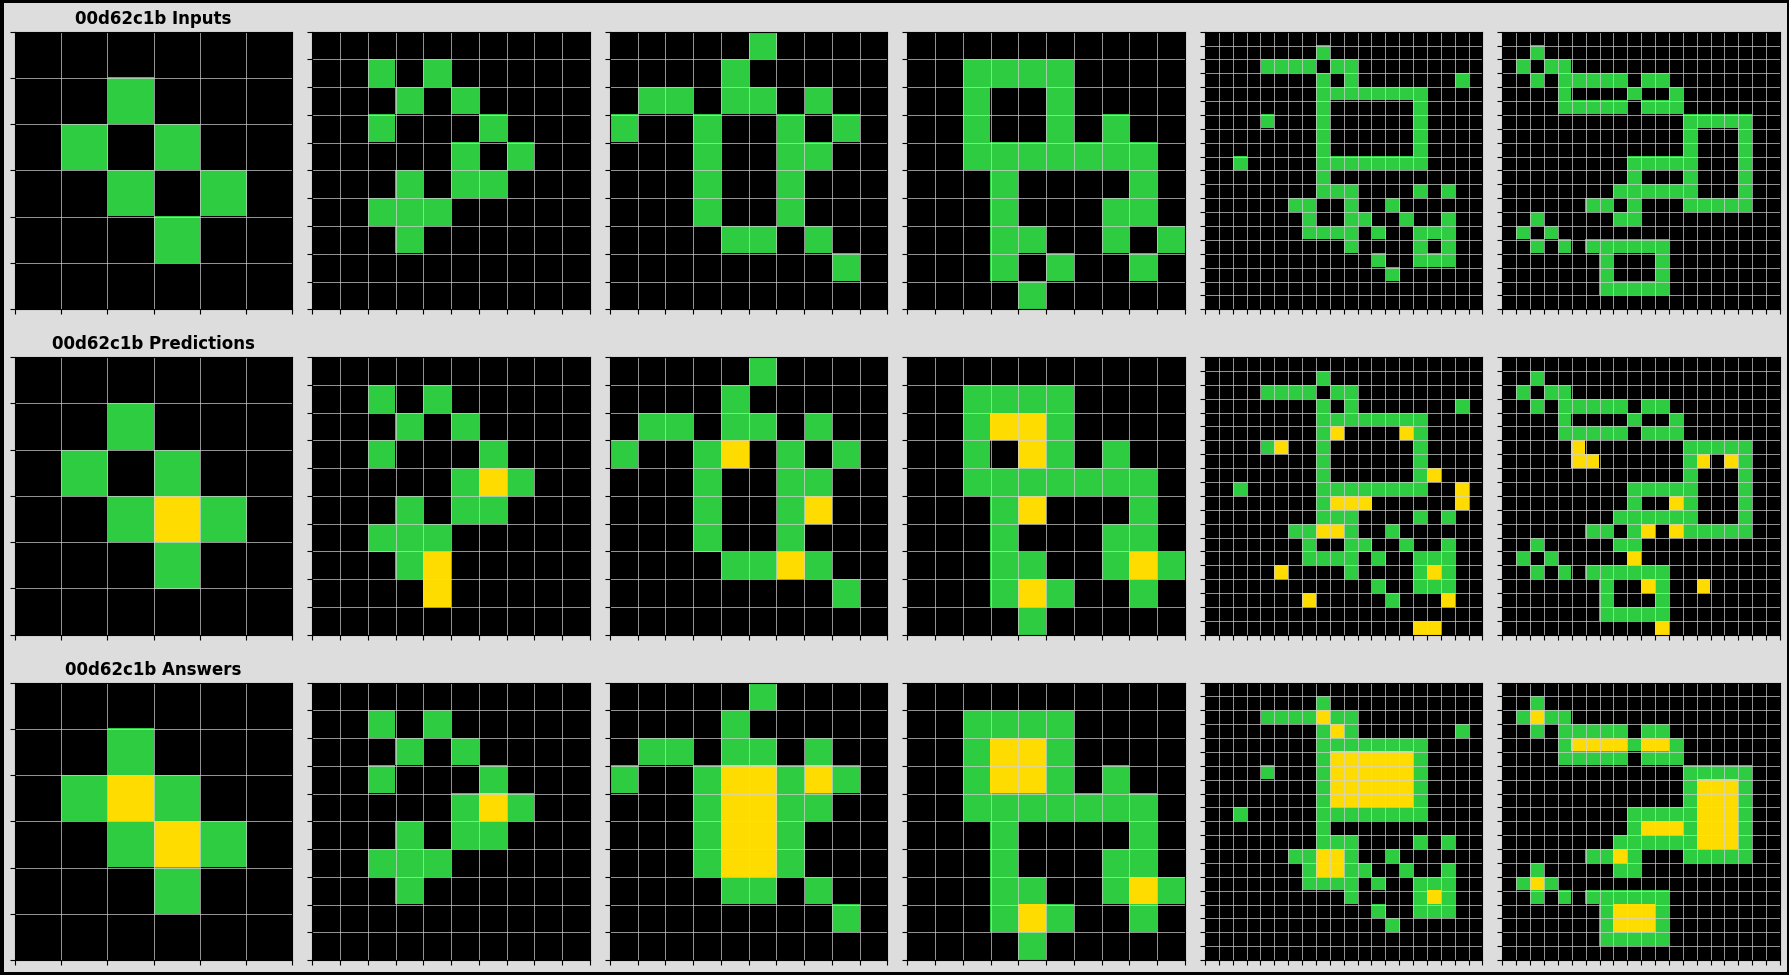

In [13]:
config = load_test_config()
config.model_path = './output/model_ShapeStableSolver.pth'
test(config)

# Step 3: Customize the model

## Model which only predicts the positions to be substituted

In [14]:
import torch
from torch import nn

from arc_prize.model_components.convfixedkernel import Conv2dEncoderLayer
from utils.visualize import plot_kernels_and_outputs
from arc_prize.model_components.attention import ReductiveAttention


class ConvFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 128, 32], reduced_channels_decoder=[128, 32], recursion=3):
        super().__init__()
        self.recursion = recursion
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.decoder = Conv2dEncoderLayer(reduced_channels_decoder[-1], reduced_channels_decoder, pad_value=pad_value, out_one_channel=True)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(reduced_channels_decoder[-1]))

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = x_c.unsqueeze(0) + 1 # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            x_c_seqs = []
            for _ in range(self.recursion): ### Depends on Input Shape
                x_c = self.extender(x_c) # [N, V, H, W]
                x_c_seqs.append(x_c.unsqueeze(0))
            x_c_seqs = torch.cat(x_c_seqs) # [S, N, V, H, W]

            S, N, V, H, W = x_c_seqs.shape
            x_c_seqs = x_c_seqs.permute(1, 3, 4, 0, 2).view(N*H*W, S, V)
            x_c = self.attn_reduction(x_c_seqs, self.attn_h.repeat(N*H*W, 1)).view(N, H, W, V).permute(0, 3, 1, 2)
            x_c = self.decoder(x_c).view(N, H, W) # [1, N, H, W]
            x_list.append(x_c.unsqueeze(0))

        x = torch.cat(x_list) 

        return x.transpose(1, 0) # [N, C, H, W]
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class ShapeStableSolverIgnoreColor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 128, 32], reduced_channels_decoder=[128, 32], n_classes=10, hidden_size=64):
        super().__init__()
        self.feature_extractor = ConvFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder)

    def forward(self, x):
        N, C, H, W = x.shape

        x = self.feature_extractor(x) # [N, C, H, W]
        y_source = x[:, 1:].sum(dim=1).view(N, H, W)

        return y_source

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)


In [15]:
model_class = ShapeStableSolverIgnoreColor
config = load_train_config(ignore_color=True)
config.model.params.reduced_channels_encoder = [512, 16]
config.model.params.reduced_channels_decoder = [16, 16]

train(config, model_class) # Apply custom model

data:
  name: ShapeStableSolverIgnoreColor
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: ShapeStableSolverIgnoreColor
  params:
    reduced_channels_encoder:
    - 512
    - 16
    reduced_channels_decoder:
    - 16
    - 16
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: ShapeStableSolver_train
- model: ShapeStableSolver
- train: default
save_path: ./output/

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolverIgnoreColor │ 13.4 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss            │      0 │ train │
└───┴────────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 13.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 13.4 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 23.068527, N Pixels Wrong: 1133

Train loss: 20.919044, N Pixels Wrong: 830

Train loss: 20.448471, N Pixels Wrong: 780

Train loss: 19.741058, N Pixels Wrong: 512

Train loss: 19.326487, N Pixels Wrong: 392

Train loss: 19.033968, N Pixels Wrong: 190

Train loss: 18.923151, N Pixels Wrong: 146

Train loss: 18.851109, N Pixels Wrong: 104

Train loss: 18.813921, N Pixels Wrong: 105

Train loss: 18.783941, N Pixels Wrong: 38

Train loss: 18.748360, N Pixels Wrong: 25

Train loss: 18.718374, N Pixels Wrong: 10

Train loss: 18.715450, N Pixels Wrong: 12

Train loss: 18.710167, N Pixels Wrong: 3

Train loss: 18.714834, N Pixels Wrong: 13

Train loss: 18.711269, N Pixels Wrong: 4

Train loss: 18.710443, N Pixels Wrong: 4

Train loss: 18.709858, N Pixels Wrong: 2

Train loss: 18.710005, N Pixels Wrong: 2

Train loss: 18.707920, N Pixels Wrong: 3

Train loss: 18.710001, N Pixels Wrong: 4

Train loss: 18.714212, N Pixels Wrong: 2

Train loss: 18.716059, N Pixels Wrong: 2

Train loss: 18.709448, N Pixels Wrong: 1

Train loss: 18.706604, N Pixels Wrong: 0

Train loss: 18.709764, N Pixels Wrong: 1

Train loss: 18.710213, N Pixels Wrong: 4

Train loss: 18.719719, N Pixels Wrong: 4

Train loss: 18.717291, N Pixels Wrong: 5

Train loss: 18.713837, N Pixels Wrong: 5

Train loss: 18.706896, N Pixels Wrong: 3

Train loss: 18.714027, N Pixels Wrong: 2

Train loss: 18.719873, N Pixels Wrong: 13

Train loss: 18.727638, N Pixels Wrong: 6

Train loss: 18.724194, N Pixels Wrong: 13

Train loss: 18.717552, N Pixels Wrong: 5

Train loss: 18.718388, N Pixels Wrong: 6

Train loss: 18.719337, N Pixels Wrong: 11

Train loss: 18.724062, N Pixels Wrong: 10

Train loss: 18.796339, N Pixels Wrong: 47

Train loss: 18.895802, N Pixels Wrong: 84

Train loss: 19.316364, N Pixels Wrong: 241

Train loss: 19.704021, N Pixels Wrong: 361

Train loss: 19.408920, N Pixels Wrong: 387

Train loss: 19.324423, N Pixels Wrong: 220

Train loss: 18.919661, N Pixels Wrong: 107

Train loss: 18.794125, N Pixels Wrong: 69

Train loss: 18.736151, N Pixels Wrong: 33

Train loss: 18.712637, N Pixels Wrong: 12

Train loss: 18.708660, N Pixels Wrong: 10

Seed used 15727033954506382969

Model saved to: ./output//model_ShapeStableSolverIgnoreColor.pth

ShapeStableSolverIgnoreColorL(
  (model): ShapeStableSolverIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=16, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=16, out_features=16, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), st

## Source Code of the Latest Model

In [16]:
import torch
from torch import nn
import torch.nn.functional as F
from itertools import product
from torch.nn.modules.conv import _size_2_t, Union


class Conv2dFixedKernel(nn.Conv2d):
    def __init__(
        self, 
        in_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = False,
        padding_mode: str = 'zeros',
        device=None,
        dtype=None,
        weight=None, 
        update=False
    ):
        if weight is None:
            weight, out_channels, biases = self.generate_all_possible_NxM_kernels(kernel_size, device=device, dtype=dtype)
        else:
            out_channels = weight.shape[0]
            biases = self.generate_biases(weight)

        super().__init__(
            in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias, padding_mode, 
            device, dtype
        )

        # Remove the default weight parameter
        del self._parameters['weight']
        del self._parameters['bias']
        
        if update:
            # Register weight as a parameter for updates
            param = nn.Parameter(weight)
            self.register_parameter('weight', param)
            
            self.bias = nn.Parameter(biases, requires_grad=update)
            self.register_parameter('bias', self.bias)
        else:
            # Set fixed weight
            self.weight = weight
            self.bias = biases

    def to(self, *args, **kwargs):
        self.weight = self.weight.to(*args, **kwargs)
        self.bias = self.bias.to(*args, **kwargs)
        return super().to(*args, **kwargs)

    @staticmethod
    def generate_all_possible_NxM_kernels(kernel_size=(3, 3), device=None, dtype=None):
        '''Generate all possible n x m kernels with values 0 and 1'''
        weight_values = [0.0, 1.0]
        repeat = kernel_size[0] * kernel_size[1]
        # Generate all possible combinations of kernel values
        weight_custom = torch.cat(
            [torch.tensor(kernel, dtype=dtype, device=device).reshape(1, 1, kernel_size[0], kernel_size[1]) 
             for kernel in product(weight_values, repeat=repeat)], dim=0)

        out_channels = len(weight_values) ** repeat
        
        # Generate corresponding biases
        biases = -(torch.sum(weight_custom, dim=(2, 3)) - 1).reshape(out_channels).to(device=device, dtype=dtype)
        
        return weight_custom, out_channels, biases

    @staticmethod
    def generate_biases(weight):
        '''Generate biases based on weight patterns'''
        return -(torch.sum(weight, dim=(2, 3)) - 1).reshape(weight.shape[0])


class Conv2dEncoderLayer(nn.Module):
    def __init__(self, in_channels=1, reduced_channels=[512, 32], fixed_kernel=False, out_one_channel=False, kernel_size=(3, 3), stride=1, padding=1, pad_value=-1):
        super().__init__()
        self.padding = padding
        self.pad_value = pad_value

        if fixed_kernel:
            self.conv = Conv2dFixedKernel(in_channels, kernel_size=kernel_size, stride=stride, padding=0)
        else:
            self.conv = nn.Conv2d(in_channels, reduced_channels[0], kernel_size=kernel_size, stride=stride, padding=0, bias=True)
        self.activation = nn.ReLU()

        self.linear_layers = nn.Sequential()
        for i in range(len(reduced_channels)-1):
            self.linear_layers.add_module(f'linear_{i}', nn.Linear(reduced_channels[i], reduced_channels[i+1], bias=False))
            self.linear_layers.add_module(f'relu_{i}', nn.ReLU())
            
        if out_one_channel:
            self.linear_layers.add_module('out', nn.Linear(reduced_channels[-1], 1, bias=False))

        self.norm = nn.InstanceNorm2d(reduced_channels[-1])

    def forward(self, x):
        N, H, W = x.shape[0], x.shape[2], x.shape[3]
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding), mode='constant', value=self.pad_value)
        x = self.activation(self.conv(x)) # [N, C, H, W]
        x = x.permute(0, 2, 3, 1).reshape(N*H*W, -1) # [N*H*W, C]
        x = self.linear_layers(x)
        x = x.view(N, H, W, -1).permute(0, 3, 1, 2)
        x = self.norm(x)

        return x

    def to(self, *args, **kwargs):
        self.conv = self.conv.to(*args, **kwargs)
        return super().to(*args, **kwargs)

In [17]:
# https://github.com/oreilly-japan/deep-learning-from-scratch-2/blob/master/ch08/attention_seq2seq.py

class AttentionWeight(nn.Module):
    def __init__(self):
        super(AttentionWeight, self).__init__()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        # Expanding h to match hs's dimensions for batch-wise multiplication
        hr = h.unsqueeze(1)  # shape: batch_size x 1 x hidden_dim
        t = hs * hr
        s = torch.sum(t, dim=2)  # Sum across hidden_dim
        a = F.softmax(s, dim=1)  # Apply softmax across seq_len
        return a

class WeightSum(nn.Module):
    def __init__(self):
        super(WeightSum, self).__init__()

    def forward(self, hs, a):
        # hs: batch_size x seq_len x hidden_dim
        # a: batch_size x seq_len
        # Need to expand a for element-wise multiplication
        ar = a.unsqueeze(2)  # shape: batch_size x seq_len x 1
        t = hs * ar
        c = torch.sum(t, dim=1)  # Sum across seq_len
        return c

class ReductiveAttention(nn.Module):
    def __init__(self):
        super(ReductiveAttention, self).__init__()
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()

    def forward(self, hs, h):
        # hs: batch_size x seq_len x hidden_dim
        # h: batch_size x hidden_dim
        a = self.attention_weight_layer(hs, h)
        out = self.weight_sum_layer(hs, a)
        return out

In [18]:
class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[512, 32], hidden_dim=16, out_dim=4):
        super().__init__()
        self.out_dim = out_dim
        self.V = reduced_channels_encoder[-1]
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(self.V))

        self.decoder = nn.Sequential(
            nn.Linear(self.V, out_dim, bias=True),
        )

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1,  self.out_dim, 1, 1) # default value is -1 so add 1 to make zero
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]

            features_time = []
            features_time.append(x_c.unsqueeze(0))

            for _ in range(max(H, W)//2+1): ### Varialble (Depends on Input Shape)
                x_c = self.extender(x_c) # [N, V, H, W]
                features_time.append(x_c.unsqueeze(0))
            features_time = torch.cat(features_time) # [S, N, V, H, W]

            S, N, V, H, W = features_time.shape
            features_time = features_time.permute(1, 3, 4, 0, 2).view(N*H*W, S, V)
            feature = self.attn_reduction(features_time, self.attn_h.repeat(N*H*W, 1))

            x_c = self.decoder(feature)  # [N*H*W, V]
            x_c = x_c.view(N, H, W, self.V).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]
        return x
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class ShapeStableSolver(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], num_classes=10, feature_dim=32):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder, out_dim=feature_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=num_classes, nhead=1, dim_feedforward=128, batch_first=True, bias=True),
            num_layers=1,
        )

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 1, bias=False),
            nn.BatchNorm1d(1),
        )

    def forward(self, x):
        N, C, H, W = x.shape
        feature = self.feature_extractor(x) # [C, N, V, H, W]
        V = feature.shape[2]
        feature = feature.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, V) # [N*H*W, C, V]

        y = feature
        y = y.transpose(2, 1)
        y = self.encoder(y)

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1) # [N*H*W, V, C]
        y = self.attn_input(y, x) # [N*H*W, V, C]
        y = y.transpose(2, 1)

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)


data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 32
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: ShapeStableSolver_train
- model: ShapeStableSolver
- train: default
save_path: ./output/

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolver │ 31.8 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss │      0 │ train │
└───┴────────────────┴───────────────────┴────────┴───────┘

Trainable params: 31.8 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 31.8 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 16.918377, N Pixels Wrong: 974

Train loss: 11.227649, N Pixels Wrong: 383

Train loss: 8.094094, N Pixels Wrong: 330

Train loss: 6.023168, N Pixels Wrong: 257

Train loss: 4.626126, N Pixels Wrong: 182

Train loss: 3.651896, N Pixels Wrong: 149

Train loss: 3.051570, N Pixels Wrong: 131

Train loss: 2.477833, N Pixels Wrong: 80

Train loss: 2.147827, N Pixels Wrong: 92

Train loss: 1.981871, N Pixels Wrong: 119

Train loss: 1.739437, N Pixels Wrong: 84

Train loss: 1.494045, N Pixels Wrong: 80

Train loss: 1.339743, N Pixels Wrong: 77

Train loss: 1.352733, N Pixels Wrong: 105

Train loss: 1.189514, N Pixels Wrong: 101

Train loss: 0.989641, N Pixels Wrong: 62

Train loss: 0.927895, N Pixels Wrong: 46

Train loss: 0.863288, N Pixels Wrong: 53

Train loss: 0.722255, N Pixels Wrong: 29

Train loss: 0.666437, N Pixels Wrong: 27

Train loss: 0.623198, N Pixels Wrong: 25

Train loss: 0.572641, N Pixels Wrong: 11

Train loss: 0.487046, N Pixels Wrong: 5

Train loss: 0.451989, N Pixels Wrong: 3

Train loss: 0.420833, N Pixels Wrong: 1

Train loss: 0.398321, N Pixels Wrong: 5

Train loss: 0.386218, N Pixels Wrong: 13

Train loss: 0.378256, N Pixels Wrong: 18

Train loss: 0.908559, N Pixels Wrong: 174

Train loss: 0.443694, N Pixels Wrong: 52

Train loss: 0.425512, N Pixels Wrong: 43

Train loss: 0.367120, N Pixels Wrong: 39

Train loss: 0.312700, N Pixels Wrong: 28

Train loss: 0.319710, N Pixels Wrong: 15

Train loss: 0.296017, N Pixels Wrong: 27

Train loss: 0.248058, N Pixels Wrong: 12

Train loss: 0.228846, N Pixels Wrong: 6

Train loss: 0.212930, N Pixels Wrong: 1

Train loss: 0.201576, N Pixels Wrong: 1

Train loss: 0.191452, N Pixels Wrong: 0

Train loss: 0.182751, N Pixels Wrong: 0

Train loss: 0.174772, N Pixels Wrong: 0

Train loss: 0.167410, N Pixels Wrong: 0

Train loss: 0.160643, N Pixels Wrong: 0

Train loss: 0.154059, N Pixels Wrong: 0

Train loss: 0.147818, N Pixels Wrong: 0

Train loss: 0.142192, N Pixels Wrong: 0

Train loss: 0.136833, N Pixels Wrong: 0

Train loss: 0.131738, N Pixels Wrong: 0

Train loss: 0.127009, N Pixels Wrong: 0

Seed used 16828693311780355445

Model saved to: ./output//model_ShapeStableSolver.pth

ShapeStableSolverL(
  (model): ShapeStableSolver(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=32, out_features=32, bias=False)
          (relu_0): ReLU()
        )
        (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=False)
      (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

Task: 00d62c1b, index: 1, correct 100.0%, N Pixels Wrong: 0

Task: 00d62c1b, index: 2, correct 100.0%, N Pixels Wrong: 0

Task: 00d62c1b, index: 3, correct 100.0%, N Pixels Wrong: 0

Task: 00d62c1b, index: 4, correct 100.0%, N Pixels Wrong: 0

Task: 00d62c1b, index: 5, correct 100.0%, N Pixels Wrong: 0

Task: 00d62c1b, index: 6, correct 97.0%, N Pixels Wrong: 12

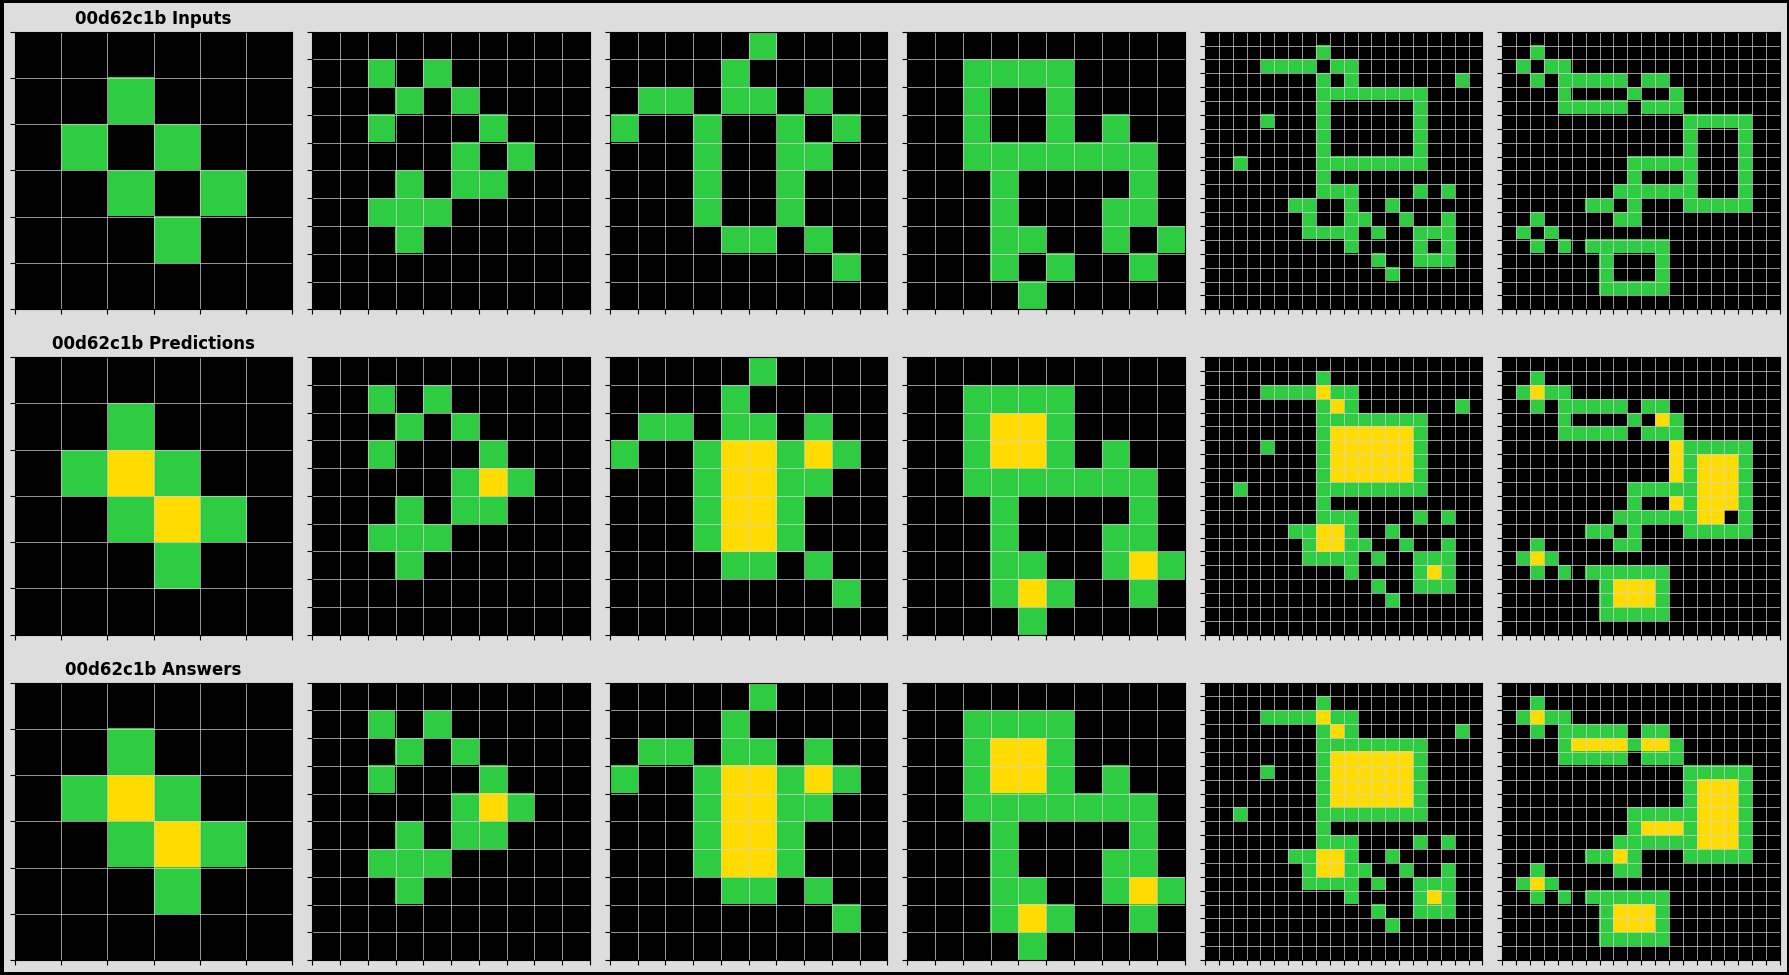

In [19]:
config = load_train_config()
model = train(config, ShapeStableSolver) # Apply custom model
print(model)
config = load_test_config()
test(config, model)